In [1]:
import jax
import jax.numpy as jnp

from flowjax.distributions import Normal
from flowjax.flows import BlockNeuralAutoregressiveFlow
from flowjax.train import fit_to_data

import matplotlib.pyplot as plt

In [2]:
key = jax.random.PRNGKey(0)

I0000 00:00:1696020019.043049   32110 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
def make_data(key, n_hyper, n_samples):

    key, key_ = jax.random.split(key)
    shifts = jax.random.uniform(key_, (n_hyper, 1), minval=-10, maxval=10)
    
    key, key_ = jax.random.split(key)
    scales = jax.random.uniform(key_, (n_hyper, 1), minval=0, maxval=10)
    
    key, key_ = jax.random.split(key)
    x = jax.random.normal(key_, (1, n_samples)) * scales + shifts

    shifts = jnp.repeat(shifts, n_samples, axis=1)
    scales = jnp.repeat(scales, n_samples, axis=1)

    return x, shifts, scales

In [4]:
x, shifts, scales = make_data(key, 100, 1_000)
x.shape, shifts.shape, scales.shape

((100, 1000), (100, 1000), (100, 1000))

In [5]:
x = jnp.concatenate(x)[:, None]
shifts = jnp.concatenate(shifts)[:, None]
scales = jnp.concatenate(scales)[:, None]
c = jnp.concatenate([shifts, scales], axis=1)

In [6]:
x.shape, c.shape

((100000, 1), (100000, 2))

In [7]:
dim = x.shape[1]
cond_dim = c.shape[1]

In [8]:
base = Normal(jnp.zeros(dim), jnp.ones(dim))

key, key_ = jax.random.split(key)
flow = BlockNeuralAutoregressiveFlow(
    key_,
    base,
    cond_dim=cond_dim,
    nn_depth=1,
    nn_block_dim=10,
    flow_layers=2,
    invert=True,
    )

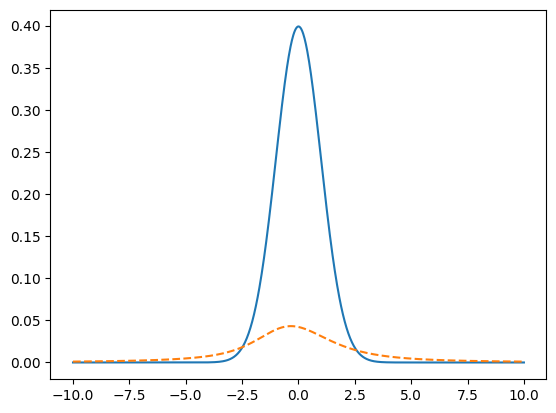

In [9]:
shift = 0
scale = 1

xx = jnp.linspace(-10, 10, 1_000)
cc = jnp.array([shift, scale])

p = jnp.exp(Normal(shift, scale).log_prob(xx))
plt.plot(xx, p)

p = jnp.exp(flow.log_prob(xx[:, None], cc))
plt.plot(xx, p, ls='--');

In [10]:
key, key_ = jax.random.split(key)
flow, losses = fit_to_data(
    key,
    flow,
    x,
    condition=c,
    max_epochs=1_000,
    max_patience=10,
    batch_size=1_000,
    val_prop=0.1,
    learning_rate=1e-3,
    show_progress=True,
    )

 14%|▋    | 144/1000 [01:36<09:33,  1.49it/s, train=2.7711236, val=2.7796977 (Max patience reached)]


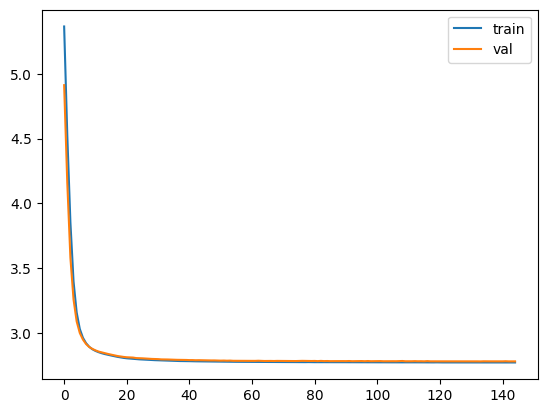

In [11]:
for label, loss in losses.items():
    plt.plot(loss, label=label)
plt.legend();

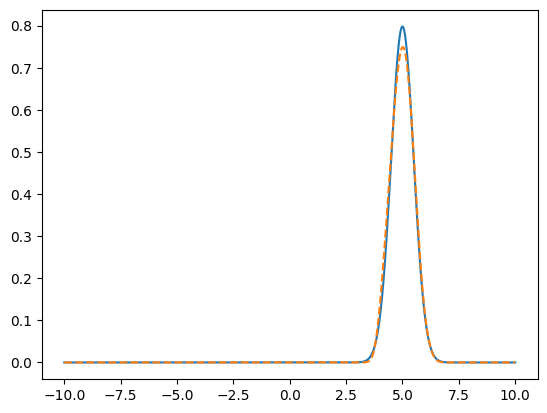

In [16]:
shift = 5
scale = 0.5

xx = jnp.linspace(-10, 10, 1_000)
cc = jnp.array([shift, scale])

p = jnp.exp(Normal(shift, scale).log_prob(xx))
plt.plot(xx, p)

p = jnp.exp(flow.log_prob(xx[:, None], cc))
plt.plot(xx, p, ls='--');